### <b>나만의 데이터 로더(Data Loader) 만들기</b>

* 딥러닝 프레임워크는 사전에 획일화된 <b>데이터 세트</b>를 제공하는 경우가 많다. (MNIST, CIFAR-10 등)
* 하지만, <b>현실 세계의 데이터 세트</b>는 그 형식이 매우 천차만별이다.
* 특정한 형식으로 구성된 데이터 세트를 불러오는 다양한 예시를 확인해 보자.

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

import os
import random
import glob
import xml.etree.ElementTree as elemTree

#### <b>PyTorch에서의 데이터</b>

* PyTorch에서는 <b>데이터 세트(Dataset)</b> 및 <b>데이터 로더(Dataloader)</b>를 사용하여 실질적으로 데이터를 불러오게 된다.
    * <b>사용 예시</b>: ① 데이터 세트(dataset) 정의 → ② 데이터 로더(data loader)로 실제 데이터 불러오기
* <b>Reference</b>: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

* 나만의 데이터 세트는 다음과 같이 구성할 수 있다.

<pre>
class CustomDataset(torch.utils.data.Dataset): 
    def __init__(self):
        # 데이터 세트에 대한 기본적인 전처리 수행

    def __len__(self):
        # 데이터 세트의 길이 (총 데이터의 개수) 반환

    def __getitem__(self, idx): 
        # 데이터 세트에서 하나의 데이터를 가져오기
</pre>



#### <b>Image Captcha 라이브러리(Library)</b>

* 특정 자릿수의 정수를 이미지 형태로 반환하는 이미지 캡차(image captcha) 라이브러리를 사용해 보자.
* <b>Reference</b>: https://pypi.org/project/captcha/

In [ ]:
!pip install captcha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 3.3 MB/s 


In [ ]:
from captcha.image import ImageCaptcha

def generate_images(directory, n_digits):
    # 디렉토리(directory)가 존재하지 않을 때
    if not os.path.exists(directory):
        os.makedirs(directory)

    # 이미지 캡차(image captcha) 객체 생성
    image = ImageCaptcha()

    # 특정한 자릿수(n_digits)만큼의 모든 정수 생성
    target = (10 ** n_digits) - 1
    for number in range(0, target + 1):
        # 문자열 형태로 변환
        string = str(number).zfill(n_digits)
        # 이미지 캡차 생성
        image.write(string, os.path.join(directory, f"{string}_0.png"))
        
        if (number + 1) % 1000 == 0:
            print(f"[Log] {number + 1} images have been generated.")

def generate_random_images(directory, n_digits, cnt):
    # 디렉토리(directory)가 존재하지 않을 때
    if not os.path.exists(directory):
        os.makedirs(directory)

    # 이미지 캡차(image captcha) 객체 생성
    image = ImageCaptcha()

    # 개수(cnt)만큼 이미지 캡차 생성
    for i in range(cnt):
        # 특정한 자릿수(n_digits)의 랜덤 정수 생성
        number = random.randint(0, (10 ** n_digits) - 1)
        # 문자열 형태로 변환
        string = str(number).zfill(n_digits)
        # 이미지 캡차 생성
        cur = 0
        path = os.path.join(directory, f"{string}_{cur}.png")
        while os.path.exists(path):
            cur += 1
            path = os.path.join(directory, f"{string}_{cur}.png")
        image.write(string, path)
        
        if (i + 1) % 1000 == 0:
            print(f"[Log] {i + 1} images have been generated.")

* 실질적으로 <b>학습용/테스트용 데이터 세트를 구축</b>할 수 있다.
* 만들어진 데이터 세트의 구성을 확인하면 다음과 같은 형태를 보인다.

<pre>
train/
  0001_0.png
  0002_0.png
  0003_0.png
  ...
test/
  0009_0.png
  0018_0.png
  0024_0.png
  ...
</pre>

In [ ]:
# 학습 데이터 세트 생성
directory = "./train"
n_digits = 4

generate_images(directory, n_digits)

# 이미지 데이터 세트 생성
directory = "./test"
n_digits = 4
cnt = 1000

generate_random_images(directory, n_digits, cnt)

[Log] 1000 images have been generated.
[Log] 2000 images have been generated.
[Log] 3000 images have been generated.
[Log] 4000 images have been generated.
[Log] 5000 images have been generated.
[Log] 6000 images have been generated.
[Log] 7000 images have been generated.
[Log] 8000 images have been generated.
[Log] 9000 images have been generated.
[Log] 10000 images have been generated.
[Log] 1000 images have been generated.


#### <b>1) 이미지 캡차(Image Captcha) 데이터 세트 불러오기</b>

* 앞서 생성한 이미지 캡차 데이터를 불러온다.

In [ ]:
class CustomCaptchaDataset(torch.utils.data.Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_path_list = glob.glob(os.path.join(self.directory, "*"))
        self.labels = []
        # 하나씩 이미지 경로를 확인하며
        for image_path in self.image_path_list:
            # 정수 데이터 부분만 확인
            label = image_path.split('/')[-1].split('_')[0]
            # 각 숫자(digit)를 리스트에 담기
            label = [int(x) for x in label]
            self.labels.append(label)

    def __len__(self):
        return len(self.image_path_list)

    def __getitem__(self, idx):
        image_path = self.image_path_list[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)

        return image, label

학습 데이터 개수: 10000


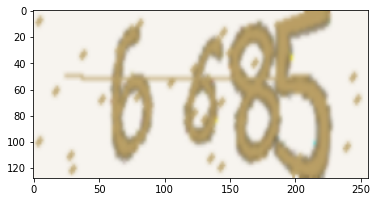

tensor([6, 6, 8, 5])


In [ ]:
def imshow(img, grayscale=False):
    npimg = img.numpy()
    # (높이, 너비, 채널) 형태로 변환
    npimg = np.transpose(npimg, (1, 2, 0))
    # 정규화 해제
    npimg = npimg * [0.5, 0.5, 0.5]
    npimg = npimg + [0.5, 0.5, 0.5]
    if grayscale:
        # 흑백 이미지는 채널 차원 제거
        npimg = np.squeeze(npimg)
        plt.imshow(npimg, cmap="gray")
    else:
        plt.imshow(npimg)
    plt.show()

train_transform = transforms.Compose([
    transforms.Resize((128, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

train_dataset = CustomCaptchaDataset("./train/", transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print(f"학습 데이터 개수: {len(train_dataset)}")
iterator = iter(train_dataloader)
imgs, labels = next(iterator)

# 배치 안에서 첫 번째 데이터 시각화
imshow(imgs[0])
print(labels[0])

테스트 데이터 개수: 1000


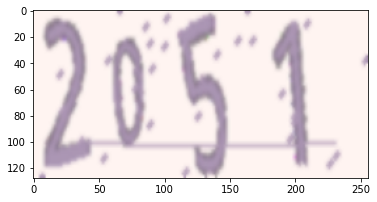

tensor([2, 0, 5, 1])


In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((128, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

test_dataset = CustomCaptchaDataset("./test/", transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"테스트 데이터 개수: {len(test_dataset)}")
iterator = iter(test_dataloader)
imgs, labels = next(iterator)

# 배치 안에서 첫 번째 데이터 시각화
imshow(imgs[0])
print(labels[0])

#### <b>2) 도로 표지판(Road Sign) 탐지 데이터 세트 불러오기</b>

* 전체 데이터 세트는 다음과 같이 구성된다.

<pre>
annotations/
  road0.xml
  road1.xml
  ...
images/
  road0.png
  road1.png
  ...
</pre>

* 이때, 하나의 <b>XML</b> 파일의 예시는 다음과 같다.
  * <b>예시 파일</b>: road0.xml

```
<annotation>
    <folder>images</folder>
    <filename>road0.png</filename>
    <size>
        <width>267</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>98</xmin>
            <ymin>62</ymin>
            <xmax>208</xmax>
            <ymax>232</ymax>
        </bndbox>
    </object>
</annotation>
```

* 파이썬(Python)의 <b>elemTree 라이브러리</b>를 이용해 XML 파일을 읽을 수 있다.

<pre>
path = "road_sign_detection_dataset/annotations/road0.xml"
tree = elemTree.parse(path)

file_name = tree.find("filename").text
object_name = tree.find("object").find("name").text

print(f"File name: {file_name}")
print(f"Object name: {object_name}")
</pre>

* 실행 결과는 다음과 같다.

<pre>
File name: road0.png
Object name: trafficlight
</pre>

* <b>Reference</b>: https://github.com/ndb796/road_sign_detection_dataset

In [ ]:
!git clone https://github.com/ndb796/road_sign_detection_dataset

Cloning into 'road_sign_detection_dataset'...
remote: Enumerating objects: 1762, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1762 (delta 0), reused 6 (delta 0), pack-reused 1756
Receiving objects: 100% (1762/1762), 217.15 MiB | 24.15 MiB/s, done.
Resolving deltas: 100% (869/869), done.


In [ ]:
class CustomRoadSignDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        # 주석(annotation) 파일 경로
        self.annotation_directory = os.path.join(self.root, "annotations")
        self.image_directory = os.path.join(self.root, "images")
        self.class_names = ["trafficlight", "stop", "speedlimit", "crosswalk"]

        self.dataset = []

        # 모든 주석(annotation)을 확인하며
        annotations = glob.glob(os.path.join(self.annotation_directory, "*"))
        for annotation in annotations:
             # XML 데이터 파싱
             tree = elemTree.parse(annotation)

             # 이미지 경로(image path)
             file_name = tree.find("filename").text
             image_path = os.path.join(self.image_directory, file_name)

             # 레이블(label)
             object_name = tree.find("object").find("name").text
             label = self.class_names.index(object_name)

             # 데이터 세트에 추가
             self.dataset.append((image_path, label))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, label = self.dataset[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)

        return image, label

데이터 세트 크기: 877


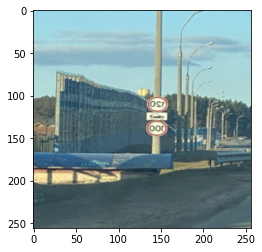

Class name: speedlimit


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

dataset = CustomRoadSignDataset(
    root="road_sign_detection_dataset",
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"데이터 세트 크기: {len(dataset)}")
iterator = iter(dataloader)
imgs, labels = next(iterator)

# 배치 안에서 첫 번째 데이터 시각화
imshow(imgs[0])
print(f"Class name: {dataset.class_names[labels[0].item()]}")

#### <b>3) 꽃(Flower) 분류 데이터 세트 불러오기</b>

* 데이터 세트의 구성을 확인하면 다음과 같은 형태를 보인다.

<pre>
Training Data/
    Daisy/
    Lavender/
    Lily/
    Rose/
    Sunflower/
Validation Data/
    Daisy/
    Lavender/
    Lily/
    Rose/
    Sunflower/
Testing Data/
    Daisy/
    Lavender/
    Lily/
    Rose/
    Sunflower/
</pre>
* <b>Reference</b>: https://github.com/ndb796/flower_classification_dataset

In [ ]:
!git clone https://github.com/ndb796/flower_classification_dataset

Cloning into 'flower_classification_dataset'...
remote: Enumerating objects: 8177, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 8177 (delta 0), reused 6 (delta 0), pack-reused 8171
Receiving objects: 100% (8177/8177), 90.27 MiB | 19.47 MiB/s, done.
Checking out files: 100% (8459/8459), done.


In [ ]:
class CustomFlowerDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        
        # 루트(root) 경로에 존재하는 모든 클래스(class) 폴더 확인
        self.directories = glob.glob(os.path.join(self.root, "*"))
        self.dataset = []
        self.class_names = []
        self.index = 0

        # 각 폴더는 클래스(class) 이름에 해당
        for directory in self.directories:
            # 클래스 이름(class name) 추가
            class_name = directory.split('/')[-1]
            self.class_names.append(class_name)
            
            # 해당 클래스의 모든 이미지를 확인하며
            image_paths = glob.glob(os.path.join(directory, "*"))
            for image_path in image_paths:
                # 이미지 경로(image path)와 레이블 번호(index) 기록
                self.dataset.append((image_path, self.index))
            
            self.index += 1

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, label = self.dataset[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)

        return image, label

학습 데이터 개수: 5000


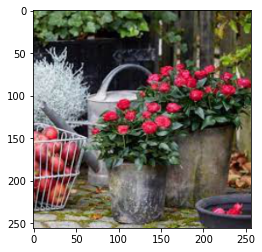

Class name: Rose


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

train_dataset = CustomFlowerDataset(
    root="flower_classification_dataset/Training Data",
    transform=train_transform
)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print(f"학습 데이터 개수: {len(train_dataset)}")
iterator = iter(train_dataloader)
imgs, labels = next(iterator)

# 배치 안에서 첫 번째 데이터 시각화
imshow(imgs[0])
print(f"Class name: {train_dataset.class_names[labels[0].item()]}")

검증 데이터 개수: 2500


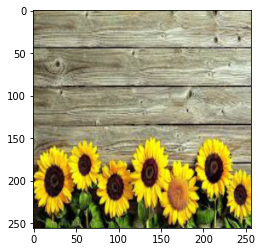

Class name: Sunflower


In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

val_dataset = CustomFlowerDataset(
    root="flower_classification_dataset/Validation Data",
    transform=val_transform
)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

print(f"검증 데이터 개수: {len(val_dataset)}")
iterator = iter(val_dataloader)
imgs, labels = next(iterator)

# 배치 안에서 첫 번째 데이터 시각화
imshow(imgs[0])
print(f"Class name: {val_dataset.class_names[labels[0].item()]}")

테스트 데이터 개수: 958


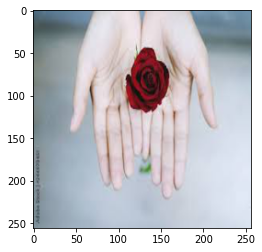

Class name: Rose


In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

test_dataset = CustomFlowerDataset(
    root="flower_classification_dataset/Testing Data",
    transform=test_transform
)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"테스트 데이터 개수: {len(test_dataset)}")
iterator = iter(test_dataloader)
imgs, labels = next(iterator)

# 배치 안에서 첫 번째 데이터 시각화
imshow(imgs[0])
print(f"Class name: {test_dataset.class_names[labels[0].item()]}")